### IMPORT

In [1]:
import os, sys
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import torch

from torchvision.utils import make_grid

from PIL import Image
from torchvision import transforms


In [2]:
if os.path.basename(os.getcwd()) == 'notebooks':
    parent_dir = os.path.abspath(os.path.join('..'))  
    sys.path.append(parent_dir) 

from src.forward_diffusion import forward_diffusion_sample
from src.data_loader import create_dataloader
from src.save_load_model import load_model_img_gen
from src.backward_diffusion import sample

### FUNCTIONS

In [3]:
def double_grid_plot(batch1, batch2, nrow=2, title="?"):
    grid1 = make_grid(batch1, nrow=nrow, normalize=True, pad_value=1)
    grid2 = make_grid(batch2, nrow=nrow, normalize=True, pad_value=1)

    np_grid1 = grid1.permute(1, 2, 0).cpu().numpy()
    np_grid2 = grid2.permute(1, 2, 0).cpu().numpy()
    
    plt.figure(figsize=(8, 4))  
    
    plt.suptitle(title, fontsize=12, y=0.95) 

    plt.subplot(1, 2, 1)
    plt.imshow(np_grid1, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(np_grid2, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()


In [4]:
def conditioned_img_gen_with_png(model, diffusion_vars, noise_steps, denoise_steps, timesteps, tensor_image, nrow):
    device = next(model.parameters()).device

    # Add batch dimension to the single image
    original_batch = tensor_image.unsqueeze(0).to(device)  # Shape: [1, 1, 256, 256]

    print(f"noise_steps = {noise_steps}")
    print(f"denoise_steps = {denoise_steps}")
    print(f"timesteps = {timesteps}")
    print("==========================")
    print(device)    
    print("==========================")


    # Add noise to the original image
    noisy_batch, _ = forward_diffusion_sample(original_batch, t=noise_steps, diffusion_variables=diffusion_vars)

    print(f"Original Image range: {original_batch.min().item()} - {original_batch.max().item()}")
    print(f"Noisy Image range: {noisy_batch.min().item()} - {noisy_batch.max().item()}")

    # Plot using the normalized version
    double_grid_plot(original_batch, noisy_batch, nrow=nrow, 
                     title=f"noise_steps = {noise_steps} | denoise_steps = 0")

    denoise_batches = []

    # Denoise the images for each specified step
    for step in denoise_steps:
        title = f"noise_steps = {noise_steps} | denoise_steps = {step}"
        
        # Perform denoising
        denoised = sample(model, noisy_batch.shape, timesteps, diffusion_vars, noisy_batch, step)
        print(f"Denoised Image range: {denoised[-1].min().item()} - {denoised[-1].max().item()}")

        # Visualize final denoised image
        denoise_batches.append(denoised[-1])
        double_grid_plot(original_batch, denoised[-1], nrow=nrow, title=title)

    return denoise_batches, original_batch, noisy_batch



### DATA LOADING 

In [5]:
# +++ RENKU
# png_path = f'../sketch.png'
# +++

# +++ LOCAL
png_path = r"C:\Users\carlo\OneDrive\Documents\04 Projects\01 CAP\01 Repos\01 Renku\oadat-ddpm\sketch2.png"
# +++


# Load and convert to grayscale
image = Image.open(png_path).convert("L")  # Convert to grayscale

# Transform to PyTorch tensor
transform = transforms.ToTensor()
tensor_image = transform(image)

# Normalize to [0, 1] and then scale to [-1, 1]
scaled_tensor = (tensor_image - tensor_image.min()) / (tensor_image.max() - tensor_image.min()) * 2 - 1

# Print properties of the scaled tensor
print(f"Scaled Image shape (C x H x W): {scaled_tensor.shape}")
print(f"Min pixel value (scaled): {scaled_tensor.min().item()}")
print(f"Max pixel value (scaled): {scaled_tensor.max().item()}")



Scaled Image shape (C x H x W): torch.Size([1, 256, 256])
Min pixel value (scaled): -1.0
Max pixel value (scaled): 1.0


### PARAMETERS

In [6]:
nrow = 2
project = 'unet'
model_name = 'init_conv_7-3'
norm_params = {"norm": 'norm1_scaleclip'}

denoise_steps = [700]
noise_steps = 600


### Backward

In [7]:
# +++ RENKU
# checkpoint_path = f'../../external_storage/poly_carlo/checkpoint/{project}/{model_name}/checkpoint.pth'
# +++

# +++ local
checkpoint_path = f'C:/Users/carlo/wandb_runs/checkpoint/{project}/{model_name}/checkpoint.pth'
# checkpoint_path = f'D:/checkpoint/{project}/{model_name}/checkpoint.pth'
# +++

In [8]:
model, config_params, diffusion_vars = load_model_img_gen(checkpoint_path)

timesteps = config_params['timesteps']
print(timesteps)

{'dim': 64, 'dim_mults': (1, 2, 4, 8), 'resnet_block_groups': 4, 'self_condition': False, 'init_kernel': 7, 'init_padding': 3}
{'learning_rate': 0.0001, 'batch_size': 10, 'epochs': 8, 'timesteps': 1000}
1000


noise_steps = 600
denoise_steps = [700]
timesteps = 1000
cuda:0
Original Image range: -1.0 - 1.0
Noisy Image range: -3.3992319107055664 - 2.951061248779297


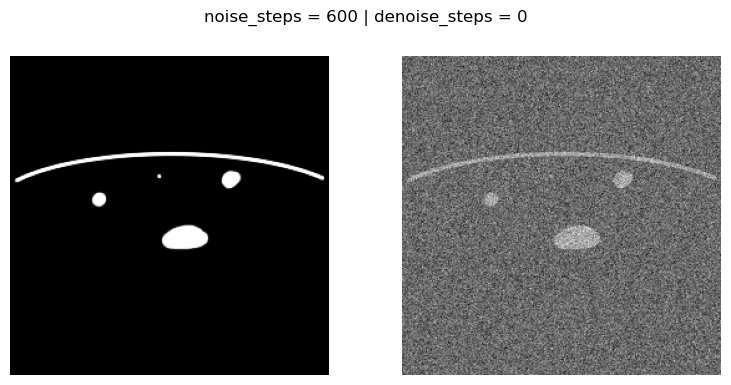

Denoised Image range: -1.203481674194336 - 1.662335753440857


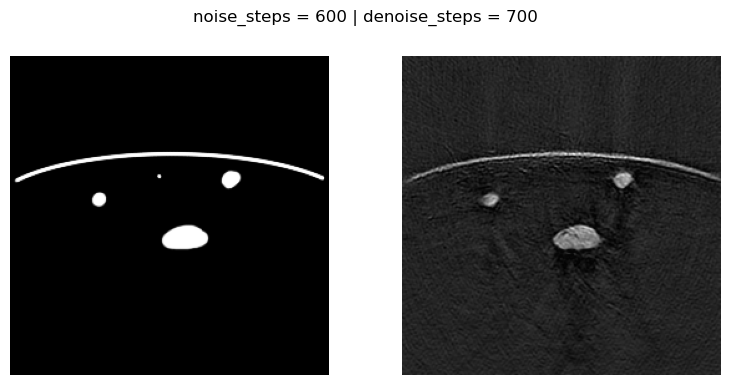

In [9]:
denoise_batches, original_batch, noisy_batch = conditioned_img_gen_with_png(
    model, diffusion_vars, noise_steps, denoise_steps, timesteps, scaled_tensor, nrow
)
